# Section 3. Few metabolic functions limit growth
What type of functions implement the predictor genes?  One could think that predictors are distributed across all metabolic activities in the sense of universal pleiotropy. However, we only find a few metabolic subsystems enriched by predictors. While these include the metabolisms of a variety of amino acids~(valine, lysine, histidine), fatty acids, and phospholipids, it is surprising the absence of other subsystems central to metabolism like glycolysis or the citric acid cycle.


## 0. Load plotting style and...

In [1]:
from matplotlib import pyplot as plt

SMALL_SIZE =  16 # 16 -> around 7pts (real Res&Size)
MEDIUM_SIZE = 20 # 20 -> around 9pts (real Res&Size)
colors = plt.style.library['seaborn-deep']['axes.prop_cycle'].by_key()['color']

# Set plot style
if 'styleDefault' not in locals():
    styleDefault = plt.rcParams.copy()
    
styleDict    = plt.style.library['seaborn-deep']
styleDict.update( { 'figure.dpi'       : 100.0        })
styleDict.update( { 'figure.facecolor' : (1,1,1,1)    })
styleDict.update( { 'axes.axisbelow'   : True         })
styleDict.update( { 'axes.labelsize'   : MEDIUM_SIZE  })
styleDict.update( { 'font.size'        : SMALL_SIZE   })
styleDict.update( { 'axes.titlesize'   : SMALL_SIZE   })
styleDict.update( { 'xtick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'ytick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'legend.fontsize'  : SMALL_SIZE   })

for key, value in styleDict.items():
    plt.rcParams[key] = value
    
    

## ... load model, bounds and...

In [2]:
import cobra
import numpy as np
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation

MODEL_NAME  = 'yeast_iND750'
SOLVER_NAME = 'glpk'


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'EX_glc__D_e' : 20 } )


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME

#... and standard medium
Q.model.medium = std_medium

#... and load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')
Q.reset_dosage()
Q.apply_dosage()


#Compute solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
wt_fluxes    = np.array( [ wt_solution.fluxes[rxnid] for rxnid in Q.NEX_RXNS] )
print('Wild-type growth rate %1.3f' % Q.slim_optimize() )

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148
Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:19:08.572439.
Wild-type growth rate 0.514


## ... PGS data from the previous section.

In [3]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error


data = np.load('Data_2_PPS_def_std.npz')
G_std    = data['G_std']  #... Genotype
f_std    = data['f_std']  #... FBA fitness
J_std    = data['J_std']  #... FBA solution fluxes
coef_std = data['B_std']  #... Effect size
R2_std   = data['R2_std'] #... PPS R2

NSAMPLES = G_std.shape[0]
NGENES   = G_std.shape[1]
NFLUXES  = J_std.shape[1]

print('Data laoded.')
print('# samples:\t%d' % NSAMPLES )
print('# genes:  \t%d' % NGENES )
print('R2 of PPS: \t%1.4f' % R2_std )





B_THRESHOLD =0.01 


#... find genes with large/small effect
large = np.argwhere(  B_THRESHOLD < np.abs(coef_std) )[:,0]
small = np.argwhere(  [ 0<np.abs(value)<B_THRESHOLD for value in coef_std] )[:,0]

#... sort the genes with descending effect size
large_ord = coef_std[large].argsort()[::-1]
small_ord = coef_std[small].argsort()[::-1]

#... concatenate both sets of large and small
values  = np.concatenate( (coef_std[large[large_ord]],coef_std[small[small_ord]]) )
indices = np.concatenate( (large[large_ord], small[small_ord]) )
labels=[ Q.model.genes[idx].name for idx in indices ]

print('N_total   = %d' % len(values) )
print('  N_large = %d' % len(large) )
print('  N_small = %d' % len(small) )
print('  N_null = %d' % (Q.N_GENES-len(large)-len(small) ) )

Data laoded.
# samples:	5000
# genes:  	750
R2 of PPS: 	0.2694
N_total   = 82
  N_large = 32
  N_small = 50
  N_null = 668


#### Create usefull matrices GxR, GxM, GxB....

In [4]:
#.......................        
# Gene-reactions matrix
GxR = np.zeros((Q.N_GENES, Q.N_NEX_RXNS))
for jj, geneid in enumerate( Q.GENES ):
    generxns = Q.model.genes.get_by_id(geneid).reactions
    for rxn in generxns:
        rxnidx = np.argwhere( rxn.id == Q.NEX_RXNS )[0][0]
        GxR[jj, rxnidx] = 1


#..................................        
# Gene-biomass *precursors* matrix
biomass_rxn =  Q.model.reactions.get_by_id( Q.BIOMASS_ID )
biomass_mtb       = [ mtb      for mtb, value in biomass_rxn.metabolites.items() if value<0]
biomass_mtb_id    = np.array( [ mtb.id   for mtb in biomass_mtb ] )
biomass_mtb_name  = np.array( [ mtb.name for mtb in biomass_mtb ] )

GxB  = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
GxB_ = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
GxB__ = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
for idxgene, geneid in enumerate(Q.GENES):
    for rxn in Q.model.genes.get_by_id(geneid).reactions:
        for mtb, value in rxn.metabolites.items():
            if mtb.id in biomass_mtb_id:
                idxmtb = np.argwhere( mtb.id == biomass_mtb_id)[0][0]
                GxB[idxgene, idxmtb]  += value
                GxB_[idxgene, idxmtb] += np.sign(value)
                GxB__[idxgene, idxmtb] += 1


#..................................        
# Reaction-biomass *precursors* matrix
NMTB= len(biomass_mtb)
RxB = np.zeros((Q.N_NEX_RXNS, NMTB))
for rxn_idx in range(Q.N_NEX_RXNS):
    rxn = Q.model.reactions.get_by_id( Q.NEX_RXNS[rxn_idx] )
    for mtb, CS in rxn.metabolites.items():
        if mtb.id in biomass_mtb_id:
            mtb_idx = np.argwhere( mtb.id == biomass_mtb_id )[0][0]
            RxB[ rxn_idx, mtb_idx ] += CS
            

#.............................        
# Define conversion functions
rxn2mtb  = lambda REACTION:   [mtb for mtb in REACTION.metabolites ]
rxn2gene = lambda REACTION:   [gene for gene in REACTION.genes ]
mtb2rxn  = lambda METABOLITE: [rxn for rxn in METABOLITE.reactions ]
gene2rxn = lambda GENE:       [rxn for rxn in GENE.reactions]

## 1. To which subsystems do predictors belong to?

Number of genes w/ none or multiple subsystem: 42
Total number of subsystems: 49


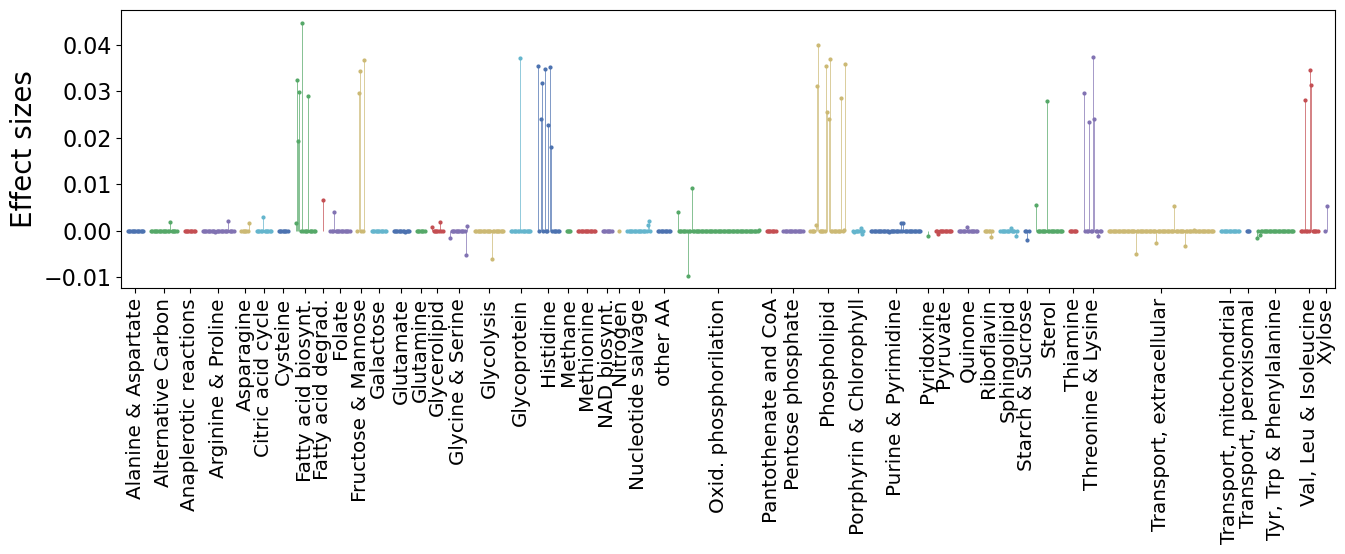

In [5]:
# First assign each gene to its subsystem
#... if the reactions in which it participates belong to more than one subsystem
#... then do not keep any subsystem
subsystem = []

n_undefined = 0
for jj in range(Q.N_GENES):
    subss = [rxn.subsystem for rxn in Q.model.genes[jj].reactions]

    if len(np.unique( subss ))==1:
        subsystem.append( np.unique(subss)[0] )
    else:
        n_undefined += 1
        subsystem.append('')
print('Number of genes w/ none or multiple subsystem: %d' % n_undefined)


unique_subsystems = np.unique(subsystem)

# Extended xlabels
xlabels_s= np.array(['Multiple subsystems','Alanine & Aspartate','Alternative Carbon','Aminosugar','Anaplerotic reactions','Arabinose','Arginine & Proline','Asparagine','Citric acid cycle','Cysteine',
'Fatty acid biosynt.','Fatty acid degrad.','Folate','Fructose & Mannose','Galactose','Glutamate','Glutamine','Glycerolipid',
'Glycine & Serine','Glycolysis','Glycoprotein','Histidine','Methane','Methionine','NAD biosynt.','Nitrogen',
'Nucleotide salvage', 'other AA', 'Oxid. phosphorilation','Pantothenate and CoA','Pentose phosphate','Phospholipid','Porphyrin & Chlorophyll',
'Purine & Pyrimidine','Pyridoxine','Pyruvate','Quinone','Riboflavin','Sphingolipid','Starch & Sucrose','Sterol','Thiamine','Threonine & Lysine',
'Transport, extracellular','Transport, mitochondrial','Transport, peroxisomal','Tyr, Trp & Phenylalanine','Val, Leu & Isoleucine','Xylose'])



print('Total number of subsystems: %d' % len(xlabels_s))

xstart = 0
xcenters = []
xlabels  = []
rr=range(len(unique_subsystems))
ignore_list = np.array(['Multiple subsystems','Arabinose','Aminosugar'])


plt.figure( figsize=( 16 , 4))

for jj, s0 in enumerate(unique_subsystems[rr]):
    if  any( xlabels_s[jj]==ignore_list) :
        continue
    
    # Obtain indices and number of genes pertaining to the subsystem s0
    iind = [idx for idx in range(len(subsystem)) if subsystem[idx] == s0]
    numel   = len(iind)

    #... determine the x-values and y-values of these genes
    xaxis = np.arange(xstart, xstart+numel)
    yaxis = coef_std[iind]
        
    #if all( abs(yaxis)< 1e-5) :
    #    continue
    
    
    xcenters.append( np.mean(xaxis) )
    #xlabels.append(s0.replace('Metabolism','metab.').replace('metabolism','metab.').replace('Biosynthesis','biosynt.'))
    xlabels.append( xlabels_s[jj] )
    
    markerline, stemlines, baseline=plt.stem(xaxis, yaxis, linefmt='none', markerfmt='none')
    baseline.set_color((0,0,0,0))

    p=plt.plot(xaxis, yaxis,'o',ms=2, ls='')
    subsystem_color = p[0].get_color()
    stemlines.set_color( subsystem_color )
    stemlines.set_linewidth( 0.5 )
    xstart += numel+5

for jj in range(len(xlabels)):
    if xlabels[jj]=='':
        xlabels[jj]='undefined'

plt.xticks(xcenters, labels = xlabels, rotation=90, fontsize=0.9*SMALL_SIZE);
#plt.grid()
plt.ylabel('Effect sizes');


pos1 = plt.gca().get_position()
pos1.y0 = pos1.y1-0.3
pos1.x0 = 0.06
pos1.x1 = 0.98
plt.gca().set_position(pos1)
plt.xlim(-5, xstart)

plt.tight_layout();

#plt.savefig('Fig_manhattan.png', dpi=300)
#plt.savefig('Fig_R2_Manhattan.png', dpi=300)

Text(0.5, 0, 'Number of predictors')

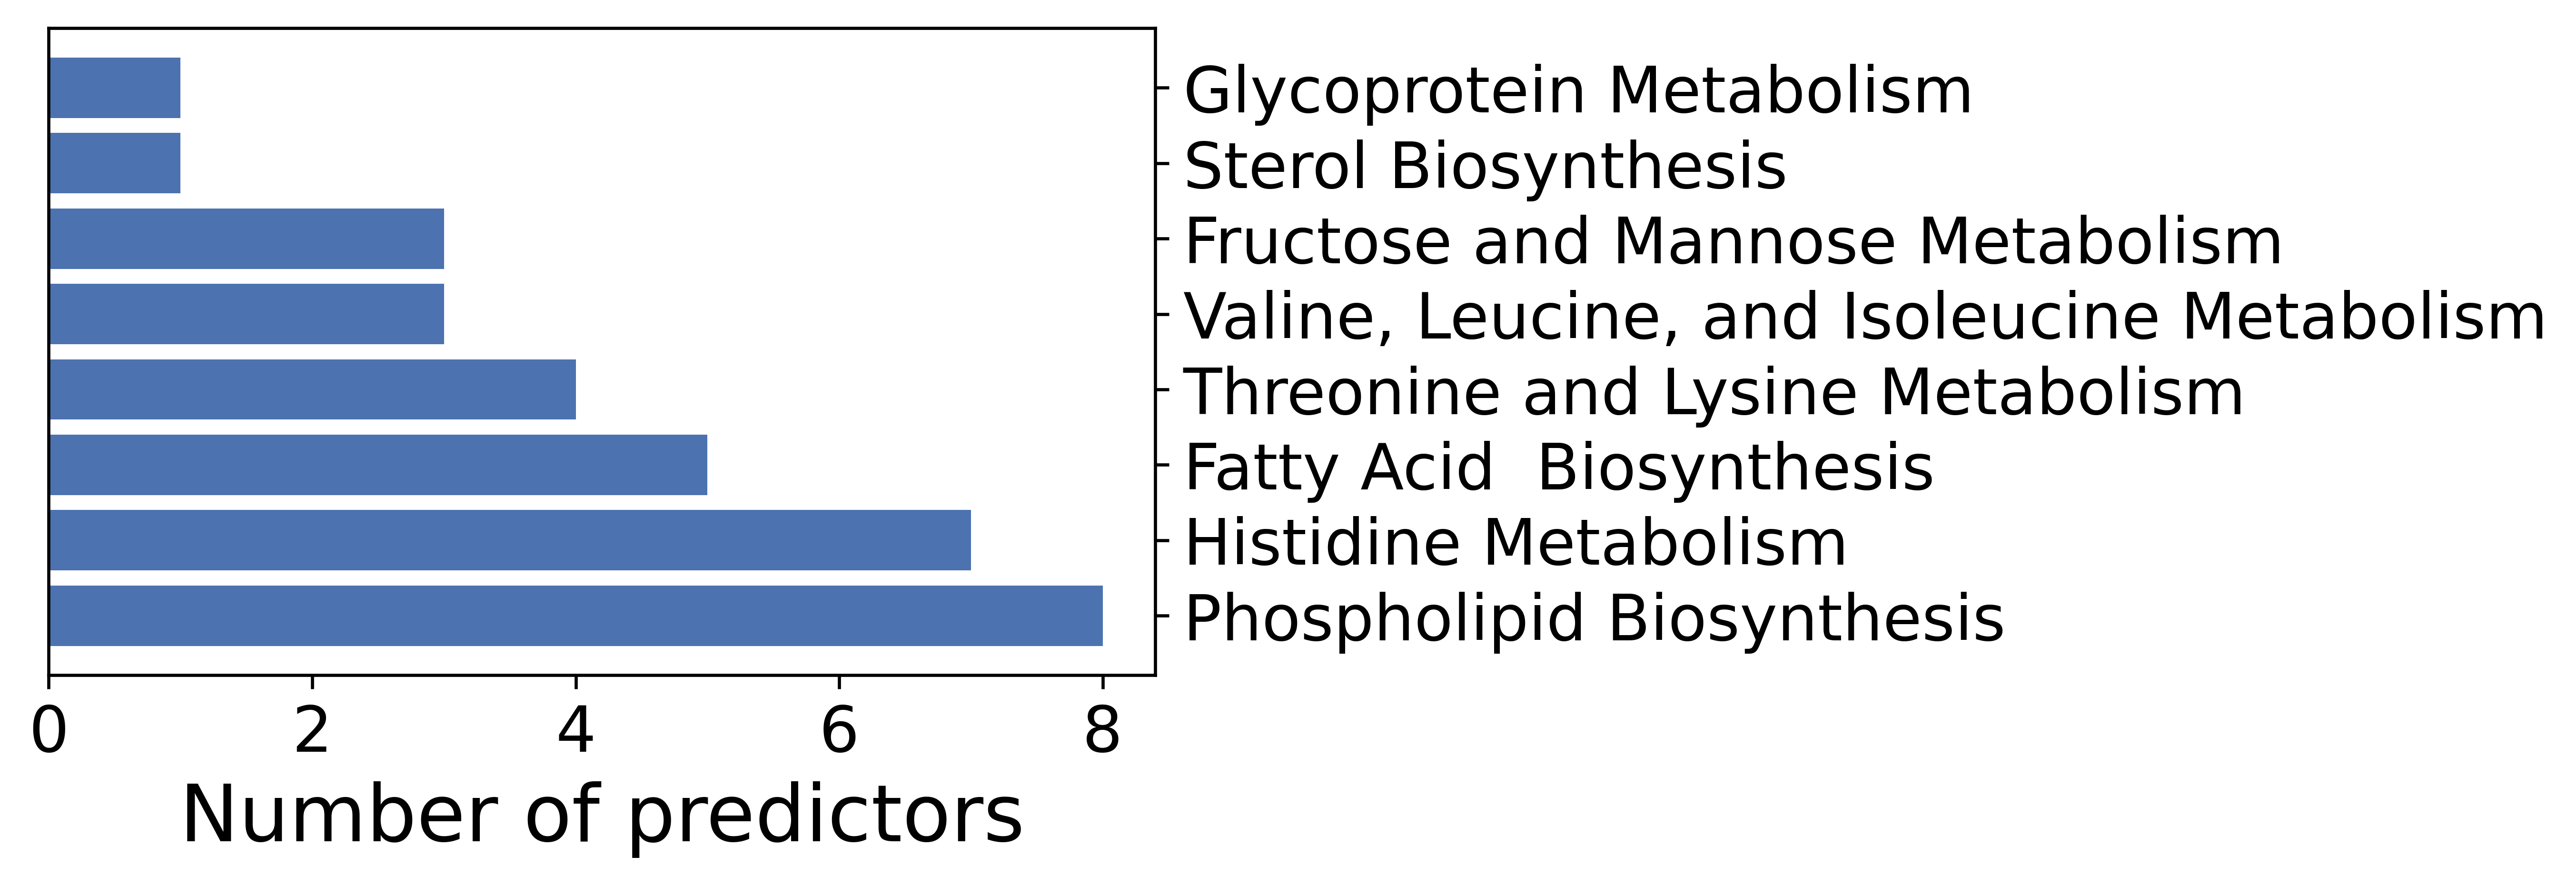

In [6]:
subsystem_idx= np.zeros(750,)
for jj, ss in enumerate( unique_subsystems):
    subsystem_idx[ np.argwhere( np.array(subsystem) == ss )[:,0] ] = jj
    
    
ss_unq = np.unique(subsystem_idx[large])
counts = np.zeros(( len( ss_unq ),))

for jj, idx in enumerate(ss_unq):
    counts[jj] = np.sum( subsystem_idx[large] == idx)

Isort = np.argsort(counts)[-1::-1]


plt.figure( figsize=( 5,3 ) , dpi=600 )
plt.gca().yaxis.tick_right()
plt.barh(range(len(ss_unq)) , counts[Isort.astype('int')])
plt.yticks( ticks= range(len(ss_unq)), labels = unique_subsystems[ss_unq[Isort.astype('int')].astype('int')], 
           rotation=0, fontsize=SMALL_SIZE)
plt.xlabel('Number of predictors')

### [plot] Detailed data...

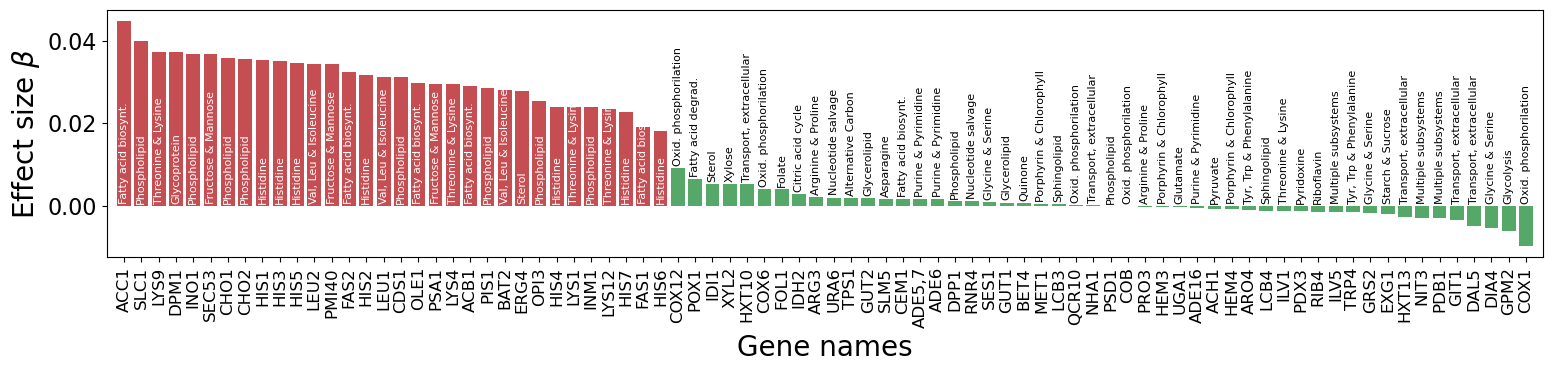

In [7]:
plt.figure( figsize=(16,4) )

b1=plt.bar(range(len(large)), coef_std[large[large_ord]], facecolor=colors[2] )
b2=plt.bar( np.arange(len(large), (len(large)+len(small)) ), coef_std[small[small_ord]], facecolor=colors[1] )

plt.xticks( range(len(indices)), labels, rotation=90, fontsize=SMALL_SIZE*0.75);
plt.xlabel('Gene names')
plt.ylabel(r'Effect size $\beta$')
plt.xlim(-1,len(indices))

for jj, idx in enumerate(indices):
    # Find the short label of the subsystem
    subsys_idx = np.argwhere( subsystem[idx] == unique_subsystems )[0][0]
    
    # If effect size is small, set the y-coord to np.max(coef, 0)
    if idx in small:
        y_coord = np.max((coef_std[idx], 0))+0.001
        txt_color = 'k'
    else:
        y_coord = 0.001
        txt_color='w'
        
    plt.text(jj, y_coord, xlabels_s[subsys_idx], 
             color = txt_color,
             rotation=90, 
             fontsize=0.50*SMALL_SIZE,
             horizontalalignment = 'center')

plt.tight_layout();

### Generate lists for GO enrichment analysis

In [8]:
with open('Data_3_predictors_large.txt','w+') as file:
    _ = [file.write( '%s\r\n' % Q.model.genes[idx].id)  for idx in large[large_ord] ]
print('List of genes with large effects exported!')

with open('Data_3_predictors_small.txt','w+') as file:
    _ = [file.write( '%s\r\n' % Q.model.genes[idx].id)  for idx in small[small_ord] ]
print('List of genes with small effects exported!')

with open('Data_3_predictors_background.txt','w+') as file:
    _ = [file.write( '%s\r\n' % gene.id)  for gene in Q.model.genes ]
print('List of background genes exported!')

List of genes with large effects exported!
List of genes with small effects exported!
List of background genes exported!


## 2. Are predictors directly related to the biomass reaction?

### [Supplementary figure] Stoichiometry of the biomass reaction

Number of metabolites involved in the biomass reaction: 43


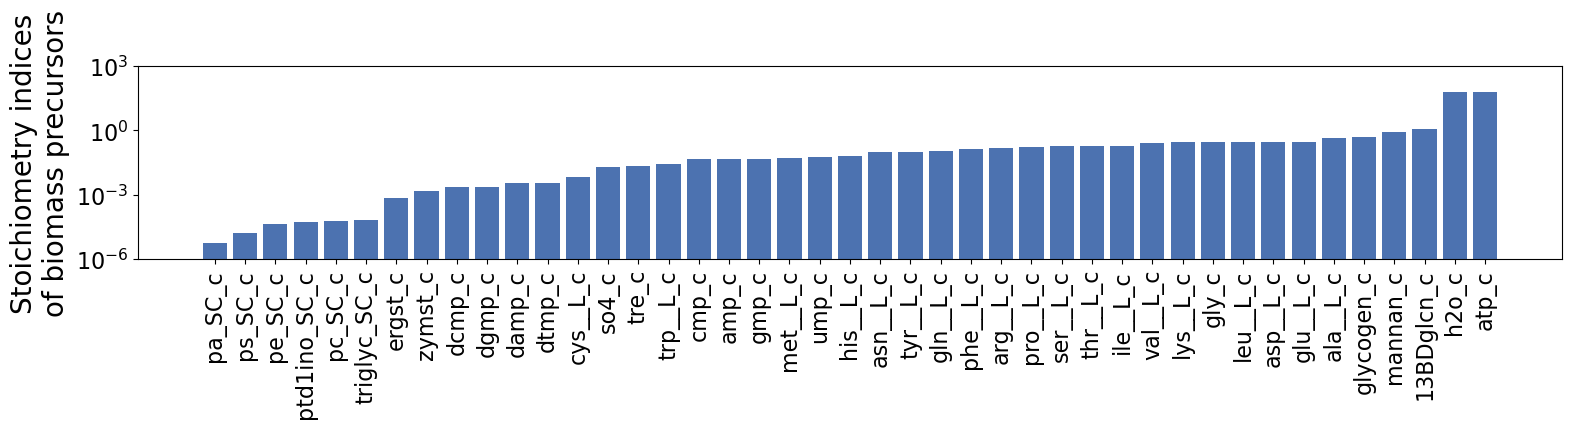

In [9]:
#... Sort according to stoichiometry value
biomass_mtb_value = np.array( [ -value for mtb, value in biomass_rxn.metabolites.items() if value<0] )
I = biomass_mtb_value.argsort()[::-1]
idxx = np.argsort( biomass_mtb_value)

plt.figure( figsize=(16,4) )

plt.bar( range(len(biomass_mtb_value)), biomass_mtb_value[idxx] )

plt.yscale('log')
plt.ylabel('Stoichiometry indices\nof biomass precursors');
plt.ylim(1e-6,1e3)
plt.xticks(range(len(I)), labels = [biomass_mtb_id[idx] for idx in idxx] , rotation=90);

plt.tight_layout();

print('Number of metabolites involved in the biomass reaction: %d' % len(biomass_mtb) )

In [10]:
### Some nice definitions ###

def sign2str(v):
    if v>0:
        return '+'
    elif v<0:
        return'-'
    else:
        return ''
    
def val2col(x, lim=0.5):
    if abs(x)>lim:
        return 'w'
    else:
        return 'k'
def p2asterisk(p, ns=''):
    if p<0.001:
        return '***'
    elif p<0.01:
        return '**'
    elif p<0.05:
        return '*'
    else:
        return ns

### [plot] Direct impact of predictors on precursor pools

([<matplotlib.axis.XTick at 0x7f0c670925b0>,
 [Text(0, 0, 'Summed\ncontribution'),
  Text(1, 0, 'Expected\nby chance'),
  Text(2, 0, 'Dedicated\nto growth')])

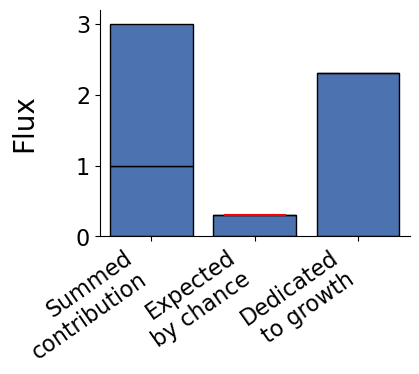

In [11]:
A = [1,0.3,2.3]
B = [2,0,0]

plt.figure( figsize=(4,3) )
plt.bar(range(3), A, edgecolor='k')
plt.bar(range(3), B, bottom=A, edgecolor='k', color=colors[0])
#plt.hlines(A[-1], -10,10,'k', ls=':')
plt.hlines(A[1], 0.7, 1.3, 'r')
plt.ylim(0,3.2)
plt.xlim(-0.5,2.5)
plt.ylabel('Flux\n   ')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks( ticks=range(3), labels=['Summed\ncontribution','Expected\nby chance','Dedicated\nto growth'],
          rotation=35, ha='right')

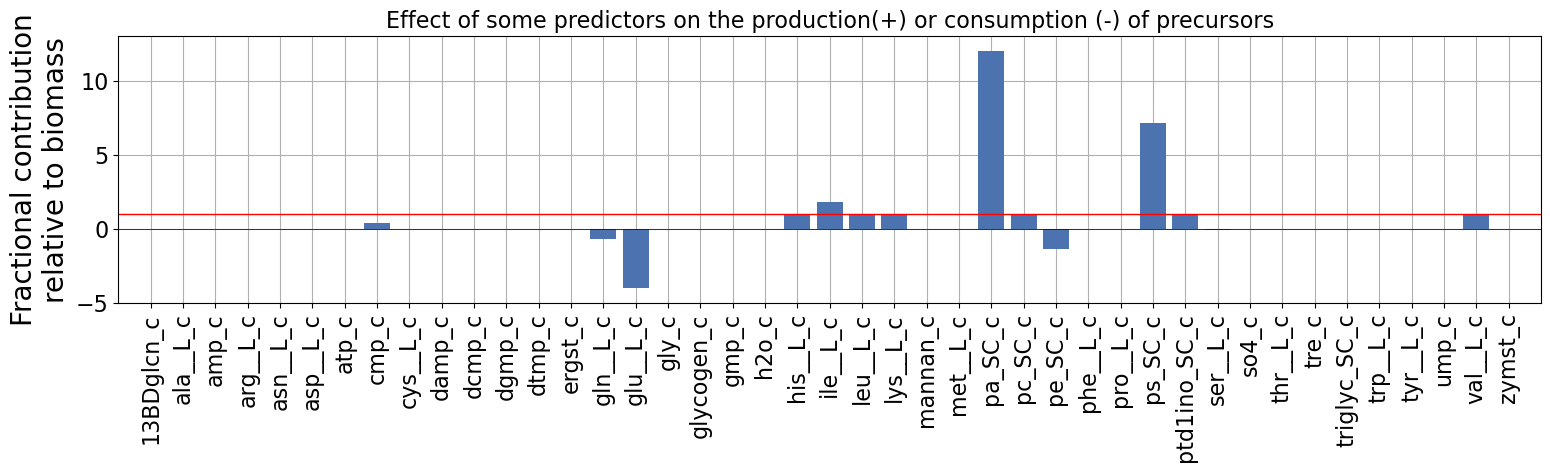

In [12]:
theta = biomass_mtb_value   #... theta is the stoichiometry index of each precursors in the biomass rxn
NMTB  = len(theta)          #... number of biomass precursors

meanJ = np.nanmean(J_std, axis=0)

# This contains the subset of reactions controlled by large effect genes 
subR = np.unique( np.nonzero( GxR[large,:])[1])

### Uncomment ###
### this to check that, all reactions contribute the total of the biomass flux
#subR = range(Q.N_NEX_RXNS) 

# M contains the production/consumption of each reaction of each precursor, in the mean metabolism
M = (meanJ*RxB.T).T

# X contains the prod/cons of precursors in a reaction subset
X = M[ subR ,:]

# Y contains the relative, fraction contribution of the reaction subset (reaction-aggregate)
Y = np.sum(X, axis=0)/theta/np.mean(f_std)


plt.figure( figsize=(16,5) )
plt.bar( range(NMTB), Y )
plt.hlines(0, -2,NMTB+1, 'k', lw=0.5)
plt.hlines(1, -2,NMTB+1, 'r', lw=1)
plt.xticks( ticks=range(NMTB), labels= biomass_mtb_id, rotation=90);
plt.ylabel('Fractional contribution\nrelative to biomass')
plt.title('Effect of some predictors on the production(+) or consumption (-) of precursors')

plt.xlim(-1, NMTB)
plt.ylim(-5,13)
plt.grid()

plt.tight_layout();

#### Montecarlo randomization to fund which contributions are significant


In [13]:
MCMAX = 20000                   # ... number of randomizations
Ymc   = np.zeros((MCMAX, NMTB)) # ... preallocate output variable

for _ in tqdm(range(MCMAX)):
    rr = np.random.permutation(Q.N_GENES)[:len(large)]
    subR = np.nonzero( GxR[rr,:])[1] #... unique reactions are taken when computing X
    M = (meanJ*RxB.T).T
    X = M[ np.unique(subR) ,:]

    Ymc[_, :] = np.sum(X, axis=0)/theta/np.mean(f_std)

pvals  = np.array( [(np.sum(Ymc[:, _]>=Y[_])+1)/(MCMAX+1) for _ in range(NMTB)] ) #... right tail
pvals_ = np.array( [(np.sum(Ymc[:, _]<=Y[_])+1)/(MCMAX+1) for _ in range(NMTB)] ) #... left tail

100%|██████████| 20000/20000 [00:15<00:00, 1259.76it/s]


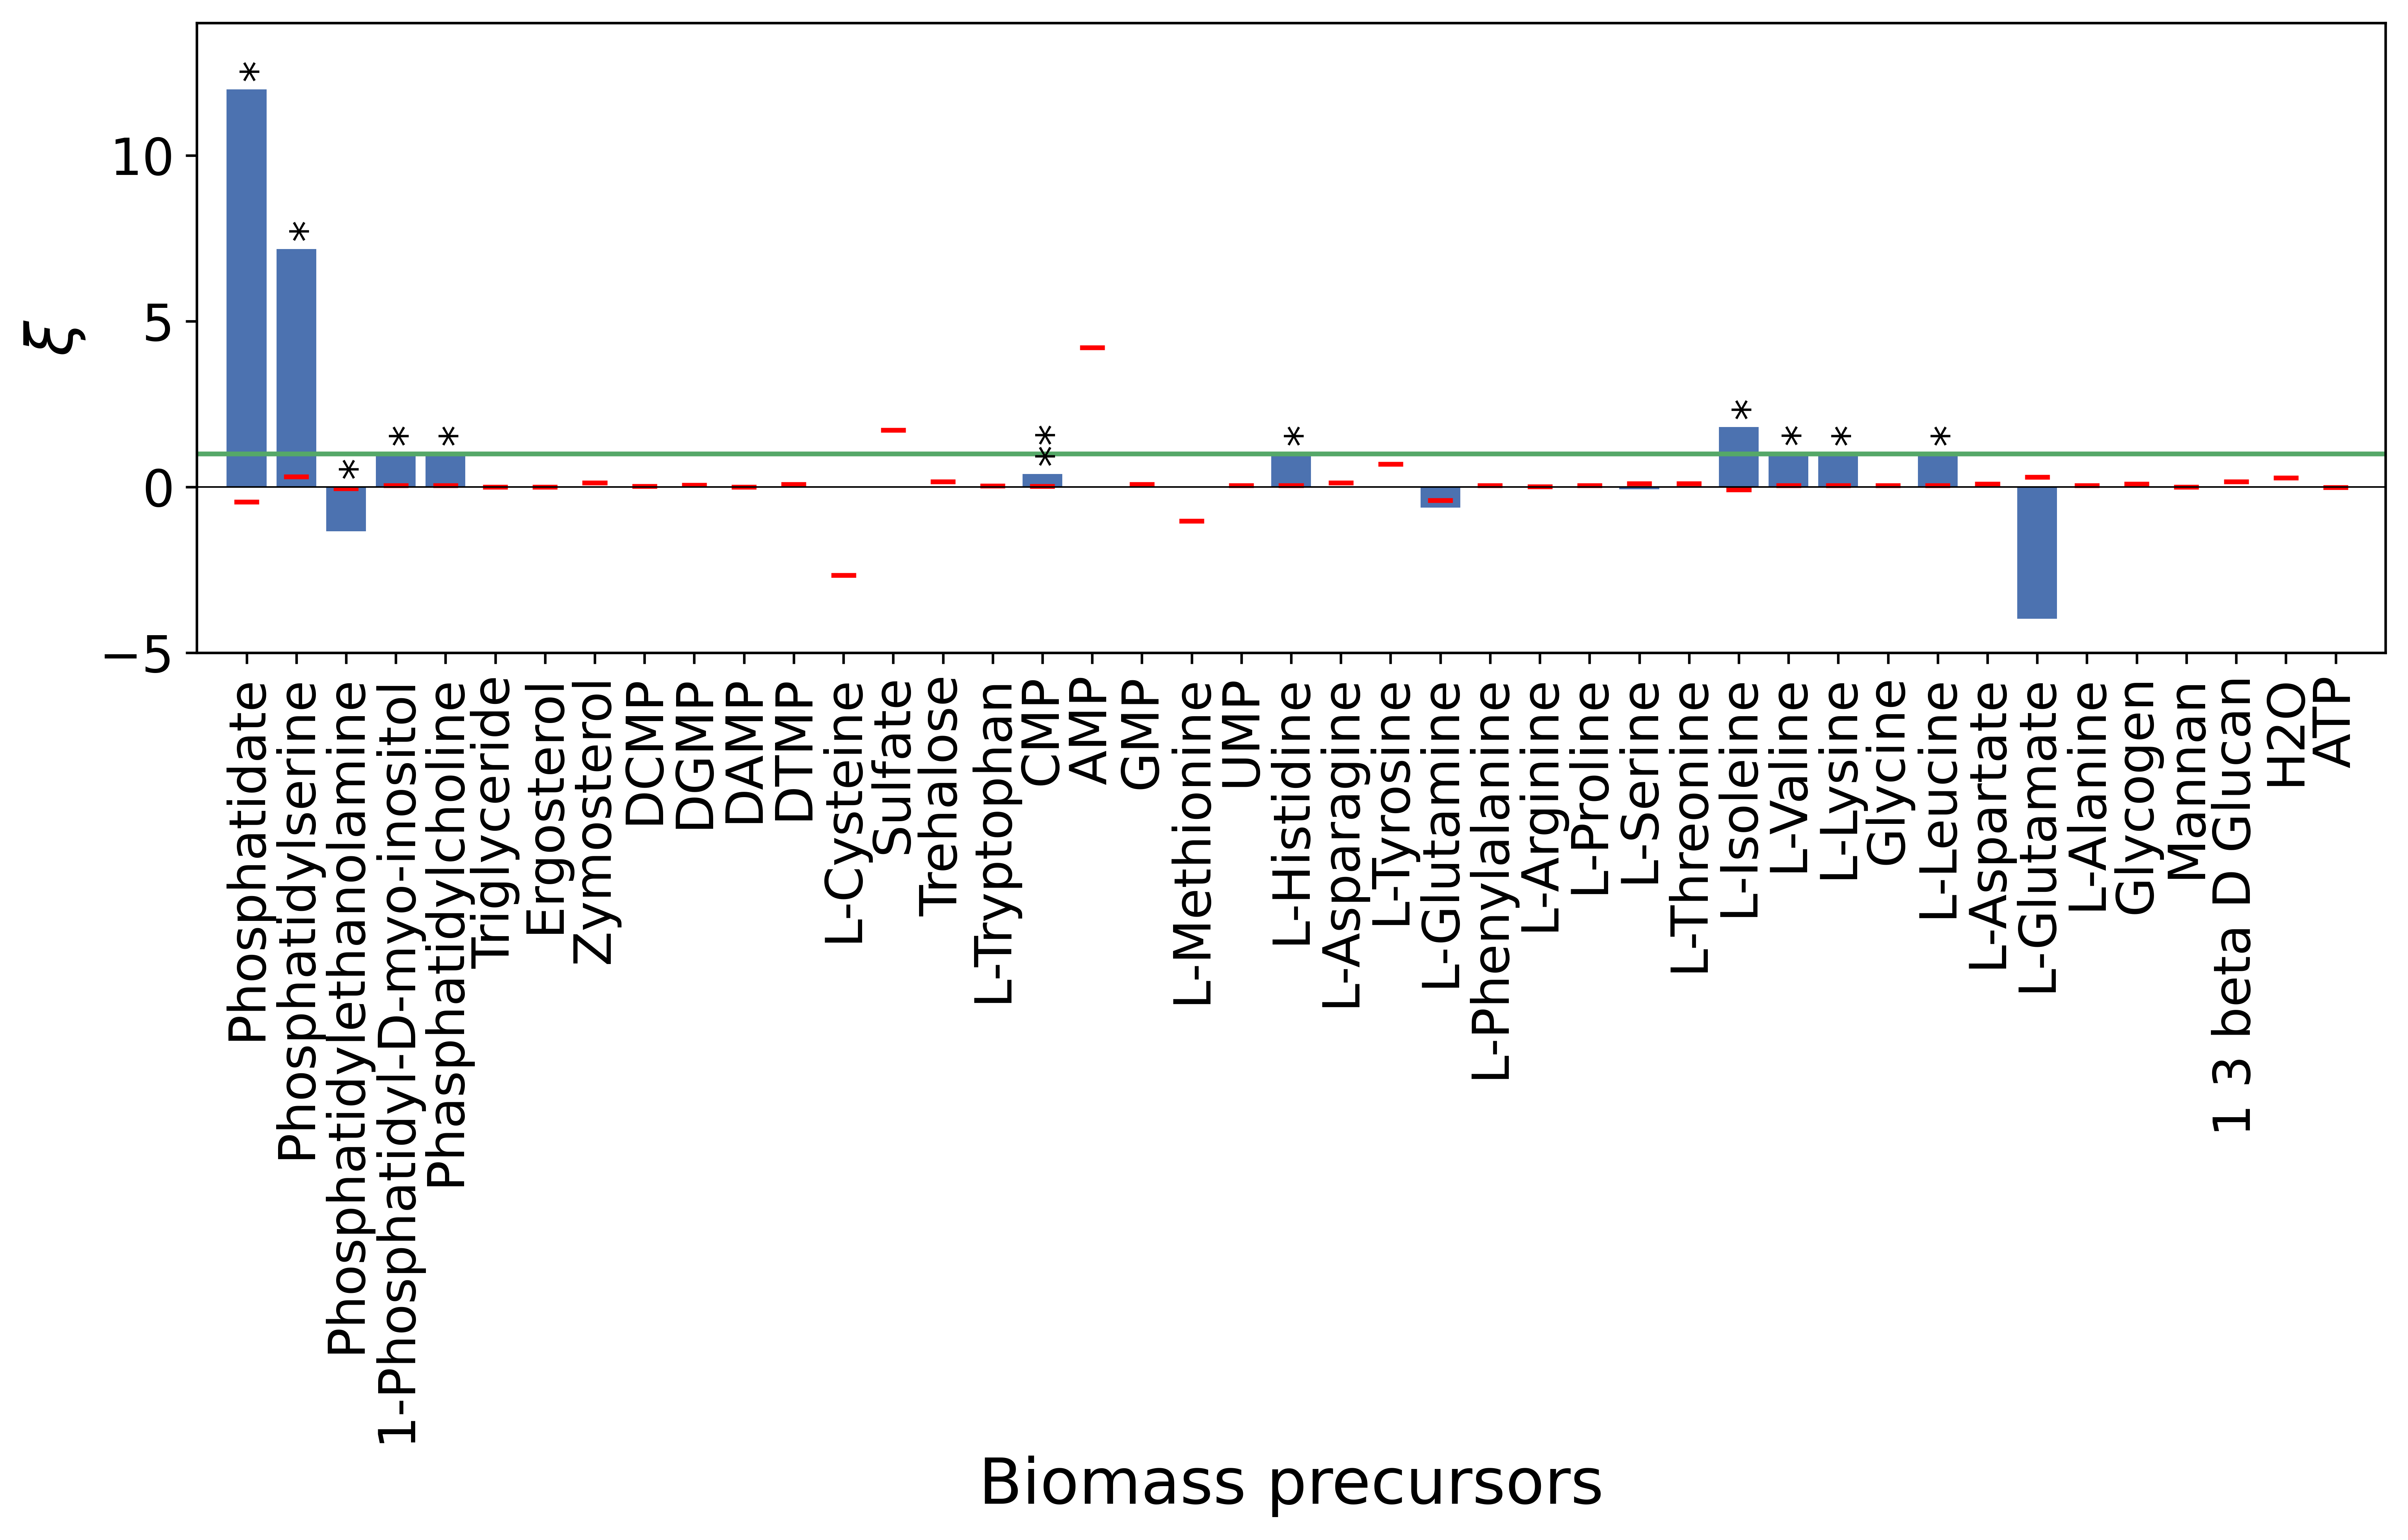

In [14]:
Isort = np.argsort(biomass_mtb_value)   #... sort precursors wrt the stoichiometry index in the biomass rxn
total_pvals = [ np.min( (pvals[_],pvals_[_]) ) for _ in range(NMTB) ]

labels=['Phosphatidate','Phosphatidylserine','Phosphatidylethanolamine','1-Phosphatidyl-D-myo-inositol','Phasphatidylcholine',
'Triglyceride','Ergosterol','Zymosterol','DCMP','DGMP','DAMP','DTMP','L-Cysteine','Sulfate','Trehalose','L-Tryptophan',
'CMP','AMP','GMP','L-Methionine','UMP','L-Histidine','L-Asparagine','L-Tyrosine','L-Glutamine','L-Phenylalanine','L-Arginine',
'L-Proline','L-Serine','L-Threonine','L-Isoleine','L-Valine','L-Lysine','Glycine','L-Leucine','L-Aspartate','L-Glutamate',
'L-Alanine','Glycogen','Mannan','1 3 beta D Glucan','H2O','ATP']


plt.rcParams['text.usetex'] = False

plt.figure( figsize=(11,7), dpi=600 )

Hbar = plt.bar(range(NMTB), Y[Isort])
Hexp = [plt.hlines(np.mean(Ymc[:,Isort[_]]), _-0.25, _+0.25,'r') for _ in range(NMTB)]
#plt.errorbar( range(NMTB), np.mean(Ymc[:,Isort], axis=0), np.std(Ymc[:,Isort], axis=0) , fmt='.r', alpha=0.5 )

Htxt = [ plt.text(_+0.25, np.max( (Y[Isort[_]], 0))+0.25 , p2asterisk(total_pvals[Isort[_]]), rotation=90,
                horizontalalignment='center',
                verticalalignment='bottom',
                color='k',
                fontsize=0.85*SMALL_SIZE)   for _ in range(NMTB)]
plt.hlines(0, -1,NMTB+1, 'k', lw=0.5)
plt.hlines(1, -1,NMTB+1, color=colors[1] , lw=1.5)


#plt.ylabel('Relative fractional\nmetabolite contribution')
plt.ylabel(r'$\xi$')
plt.xlabel('Biomass precursors')
plt.xticks( ticks=range(NMTB), labels= labels, rotation=90, fontsize=SMALL_SIZE);
plt.ylim(-5,14)
plt.xlim(-1, NMTB)

plt.tight_layout();
plt.rcParams['text.usetex'] = False

### Which genes are especially contributing to the precursor pool?

In [15]:
remarkable_precursors = np.log10(total_pvals)<np.log10(0.05)
remarkable_genes_among_large = np.argwhere( np.any( GxB[:, remarkable_precursors][large,:], axis=1))[:,0]
[print( Q.model.genes[ large[idx]].name ) for idx in remarkable_genes_among_large];

CDS1
SLC1
HIS4
BAT2
CHO2
OPI3
PIS1
CHO1
LYS1


### [Supplementary figure] The details of contributions

In [16]:
K = np.zeros((Q.N_GENES, NMTB))

# M contains the production/consumption of each reaction of each precursor, in the mean metabolism
M = (meanJ*RxB.T).T

for gene_idx in range(Q.N_GENES):    

    # X contains the prod/cons of precursors in the reaction subset of gene gene_idx
    subR = np.unique( np.nonzero( GxR[[gene_idx,],:])[1] )
    X    = M[ subR ,:]

    # Y contains the prod/cons of precursors for each gene the reaction subset (reaction-aggregate)
    K[gene_idx,:] = np.sum(X, axis=0)/theta/np.mean(f_std)

In [17]:
gene_labels = [Q.model.genes[idx].name for idx in indices]

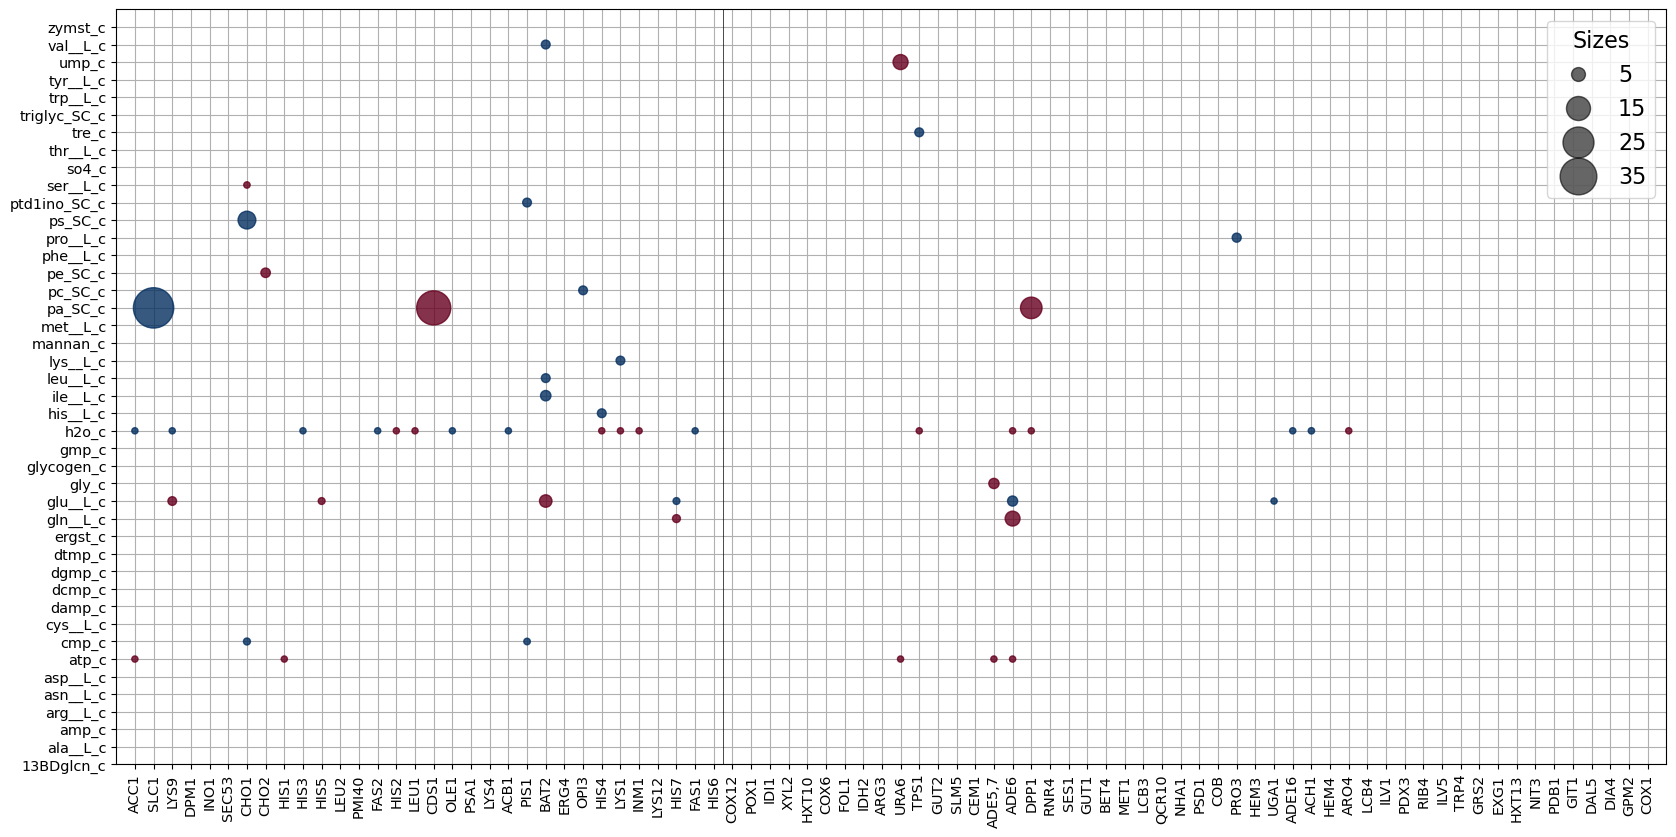

In [18]:
X = K[indices,:]
x ,y = np.nonzero(X)
s = abs(X[x,y])+1
c = np.sign(X[x,y])
size_multiplier = 20

plt.figure( figsize=(20,10) )
scatter = plt.scatter(x,y, s=size_multiplier*s, c=c, cmap='RdBu', alpha=0.8)
plt.vlines(len(large)-0.5,0,NMTB,'k', lw=0.5)

plt.yticks( ticks= range(NMTB), labels=biomass_mtb_id, fontsize=0.65*SMALL_SIZE);
plt.xticks( ticks= range(len(indices)), labels=gene_labels, rotation=90, fontsize=0.65*SMALL_SIZE);
plt.ylim(0, NMTB)
plt.xlim(-1, len(indices) )
plt.grid()
plt.gca().set_axisbelow(True)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
leg_values = [lab.replace('$\\mathdefault{','').replace('}$','') for lab in labels]
labels = [ "%1.0f" % ( float(value)/size_multiplier) for value in leg_values ]
legend2 = plt.legend(handles[0::2], labels[0::2], loc="upper right", title="Sizes")

### [Script] This is some code to help track metabolites, reactions and genes